In [1]:
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

import pytorch_lightning as pl

print(f'workspace = {Path.cwd()}')


import sys
sys.path.append(str(Path('..').resolve().absolute()))

workspace = /home/kourosh/projects/dm_sac/osil_notebooks


In [2]:
root = Path.cwd().parent

In [3]:
import dmc
import numpy as np


from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader


TASK_NAME = 'walker_stand'
OBS_TYPE = 'pixels'
BLOCK_SIZE = 1


/home/kourosh/anaconda3/envs/urlb/lib/python3.8/site-packages/glfw/__init__.py:906: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [4]:

class DMC(Dataset):

    def __init__(self, task_name='walker_stand', obs_type='state', block_size=64):

        assert obs_type in ['state', 'pixels']

        
        self.block_size = block_size

        with open(Path(root) / 'agent_runs' / f'{task_name}.pickle', 'rb') as f:
            data = pickle.load(f)
        
        self.obs = data['obs'] if obs_type == 'pixels' else data['state']
        self.acs = data['action']
        self.terminal = data['terminal']
        self.reward = data['reward']

        self.num_trajs = len(self.obs)
        self.num_cols = len(self.obs[0]) - self.block_size
    
    def __len__(self):
        return self.num_trajs * self.num_cols

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data

        traj_idx = idx // self.num_cols
        start_idx = idx % self.num_cols
        obses = self.obs[traj_idx][start_idx:start_idx + self.block_size]
        acs = self.acs[traj_idx][start_idx:start_idx + self.block_size]
        
        x = torch.tensor(obses, dtype=torch.float)
        y = torch.tensor(acs, dtype=torch.float)
        return x, y

dataset = DMC(task_name=TASK_NAME, obs_type=OBS_TYPE, block_size=BLOCK_SIZE)

loader = DataLoader(dataset, shuffle=True, pin_memory=True,
                                batch_size=256,
                                num_workers=0)


In [5]:
print(dataset.obs.shape)
print(len(dataset))
x, y = dataset[len(dataset)-1]
print('x ', x.shape)
print('y ', y.shape)

(100, 1000, 3, 84, 84)
99900
x  torch.Size([1, 3, 84, 84])
y  torch.Size([1, 6])


In [6]:
import tqdm 

class Encoder(nn.Module):
    def __init__(self, obs_shape, h_dim):
        super().__init__()

        assert len(obs_shape) == 3
        self.repr_dim = 32 * 35 * 35

        self.convnet = nn.Sequential(
            nn.Conv2d(obs_shape[0], 32, 3, stride=2),
            nn.ReLU(), 
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(), 
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU(), 
            nn.Conv2d(32, 32, 3, stride=1),
            nn.ReLU()
        )

        self.lin = nn.Linear(self.repr_dim, h_dim, bias=True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Custom weight init for Conv2D and Linear layers."""
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight.data)
            if hasattr(m.bias, 'data'):
                m.bias.data.fill_(0.0)
        elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            gain = nn.init.calculate_gain('relu')
            nn.init.orthogonal_(m.weight.data, gain)
            if hasattr(m.bias, 'data'):
                m.bias.data.fill_(0.0)

    def forward(self, obs):
        obs = obs / 255.0 - 0.5
        h = self.convnet(obs)
        h = h.view(h.shape[0], -1)
        h = self.lin(h)
        return h

class BCMLP(nn.Module):
    
    def __init__(self, conf):
        super().__init__()

        self.h_dim = h_dim = conf.h_dim
        self.obs_shape = obs_shape = conf.obs_dim
        self.ac_dim = ac_dim = conf.ac_dim
        
        self.emb = None
        if len(obs_shape) > 1:
            self.emb = Encoder(obs_shape, h_dim)

        self.mlp = nn.Sequential(nn.Linear(h_dim if self.emb else obs_shape[0], h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, ac_dim)
                                )
                
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, x):
        if self.emb:
            x = self.emb(x)
        pred_ac = self.mlp(x)
        return pred_ac
    
    def bc_loss(self, pred_ac, target_ac):
     
        pred_ac = pred_ac.view(-1, pred_ac.shape[-1])
        target_ac = target_ac.view(-1, target_ac.shape[-1])
        loss = F.mse_loss(pred_ac, target_ac)
        
        return loss
        
class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size=2, block_size=64, 
                 n_layer=4, n_head=8, n_embd=512, obs_dim=4, ac_dim=2):
        self.vocab_size = vocab_size
        self.block_size = block_size

        self.n_layer=n_layer
        self.n_head=n_head
        self.h_dim=n_embd 
        
        self.in_dim = vocab_size
        self.out_dim = vocab_size
        self.max_T = block_size
        
        self.obs_dim = obs_dim
        self.ac_dim = ac_dim
     

In [7]:

x, y = dataset[0]
conf = GPTConfig(block_size=1, n_embd=256, obs_dim=x.shape[1:], ac_dim=y.shape[-1])


weight_decay=1e-4
learning_rate=1e-4
betas=(0.99,0.999)
device = torch.device('cuda')
losses = []
epochs = 20


In [8]:
model = BCMLP(conf)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas)
model = model.to(device)


if len(model.obs_shape) > 1:
    x = torch.randn((3, 3, 84, 84)).float().to(device)
    y = model(x)
    print(y.shape)

torch.Size([3, 6])


In [13]:

for epoch in range(epochs):
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader))

    for it, (x, y) in pbar:

        # place data on the correct device
        x = x.to(device).float()
        y = y.to(device).float()

        # forward the model
        with torch.set_grad_enabled(True):
            x = x.squeeze(1)
            y = y.squeeze(1)
            pred_ac = model.forward(x)

            loss = model.bc_loss(pred_ac, y)
            loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
            losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            optimizer.step()

        if it % 1000 == 0:
            print(loss.item())

        #if it == 5000:
        #    break

  1%|▏         | 5/391 [00:00<00:19, 19.65it/s]

0.45781368017196655


  2%|▏         | 6/391 [00:00<00:14, 25.75it/s]

0.3838927745819092


  2%|▏         | 6/391 [00:00<00:14, 26.16it/s]

0.37194332480430603


  2%|▏         | 6/391 [00:00<00:14, 26.96it/s]

0.35873112082481384


  2%|▏         | 6/391 [00:00<00:14, 25.91it/s]

0.349597692489624


  2%|▏         | 6/391 [00:00<00:14, 26.00it/s]

0.3362366557121277


  2%|▏         | 6/391 [00:00<00:14, 26.47it/s]

0.3426046371459961


  2%|▏         | 6/391 [00:00<00:14, 27.10it/s]

0.3259008526802063


  2%|▏         | 6/391 [00:00<00:14, 27.23it/s]

0.30183184146881104


  2%|▏         | 7/391 [00:00<00:13, 27.73it/s]

0.3114248514175415


  2%|▏         | 6/391 [00:00<00:14, 27.45it/s]

0.3128284811973572


  2%|▏         | 7/391 [00:00<00:13, 27.78it/s]

0.2982085347175598


  2%|▏         | 6/391 [00:00<00:14, 27.35it/s]

0.3044389486312866


  2%|▏         | 6/391 [00:00<00:14, 26.74it/s]

0.28962451219558716


  2%|▏         | 6/391 [00:00<00:14, 27.05it/s]

0.28639060258865356


  2%|▏         | 6/391 [00:00<00:14, 26.56it/s]

0.29265156388282776


  2%|▏         | 6/391 [00:00<00:14, 27.42it/s]

0.2804614007472992


  2%|▏         | 6/391 [00:00<00:14, 26.91it/s]

0.26953691244125366


  2%|▏         | 6/391 [00:00<00:14, 27.47it/s]

0.2649284899234772


  2%|▏         | 6/391 [00:00<00:14, 26.76it/s]

0.2789513170719147


100%|██████████| 391/391 [00:13<00:00, 28.72it/s]


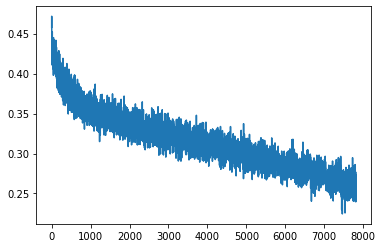

In [15]:
plt.plot(losses)

In [ ]:
env = dmc.make(TASK_NAME, seed=10, obs_type=OBS_TYPE)
pl.seed_everything(10)


timestep = env.reset()
print(timestep)


Error: Kernel is dead

In [ ]:
torch.save({
            'epoch': 10,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': np.mean(losses[-100:])
            }, './bc.pt')

# Transfromer-based BC

In [ ]:
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F


class Attention(nn.Module):
    
    def __init__(self, conf):
        super().__init__()
        
        self.n_head = conf.n_head
        h_dim = conf.h_dim
        max_T = conf.max_T
        self.qnet = nn.Linear(h_dim, h_dim)
        self.knet = nn.Linear(h_dim, h_dim)
        self.vnet = nn.Linear(h_dim, h_dim)
        
        self.proj = nn.Linear(h_dim, h_dim)
        
        mask = torch.tril(torch.ones(max_T,max_T)).view(1,1,max_T,max_T)
        self.register_buffer('mask',mask)
        
    def forward(self, x):
        # x is (B, T, C)
        assert x is not None
        B, T, C = x.shape
        N = self.n_head
        H = C // N
        assert C % N == 0
        
        q = self.qnet(x).view(B, T, N, H).transpose(1, 2)
        k = self.knet(x).view(B, T, N, H).transpose(1, 2)
        v = self.vnet(x).view(B, T, N, H).transpose(1, 2)
        
        att = q @ k.transpose(2, 3) * (1.0 / math.sqrt(H)) # (:, :, T, T)
        
        att.masked_fill(self.mask == 0, float('-inf'))
        
        att = F.softmax(att, dim=-1) # stays # (:, :, T, T)
        
        att = att @ v # (B, N, T, T) @ (B, N, T, H)
        
        # gather heads
        
        out = att.transpose(1, 2).contiguous().view(B, T, C)
        
        out = self.proj(out)
        return out
    
class Transformer(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        
        h_dim = config.h_dim
        self.attention = Attention(config)
        self.ln1 = nn.LayerNorm(h_dim)
        self.mlp = nn.Sequential(
            nn.Linear(h_dim, 4*h_dim),
            nn.ReLU(),
            nn.Linear(4*h_dim, h_dim),
        )
        self.ln2 = nn.LayerNorm(h_dim)
        
    def forward(self, x):
        
        x = x + self.attention(x)
        x = self.ln1(x)
        x = x + self.mlp(x)
        x = self.ln2(x)
        
        return x
        

class GPT(nn.Module):
    
    def __init__(self, conf):
        super().__init__()

        # token embeddings
        vocab_dim = conf.in_dim
        h_dim = conf.h_dim
        obs_dim = conf.obs_dim
        ac_dim = conf.ac_dim
        self.obs_dim = obs_dim
                
        self.token_embed = nn.Linear(vocab_dim, h_dim)
        
        self.pos_encoding = nn.Parameter(torch.zeros(1, conf.max_T, h_dim))
        
        # transformer
        self.transformer = nn.Sequential(*[Transformer(conf) for _ in range(conf.n_layer)])
        self.ln = nn.LayerNorm(h_dim)
        
        # prediction head
        self.pred_head = nn.Linear(h_dim, vocab_dim, bias=False)
        
        # policy head
        task_dim = 16
        self.task_proj = nn.Sequential(nn.Linear(h_dim, task_dim), nn.ReLU())
        self.policy_head = nn.Sequential(
            nn.Linear(task_dim + obs_dim, 4*task_dim),nn.ReLU(), nn.Linear(4*task_dim, ac_dim))
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, x):
        
        B, T, C = x.shape
        token_h = self.token_embed(x)
        pos_h = self.pos_encoding[:, :T, :]
        
        h = token_h + pos_h

        h = self.transformer(h)
        
        logits = self.pred_head(h)
                
        return logits, h
    
    def behavior_clone(self, z, x, y):
        B, T, C = x.shape
        
        diag = torch.arange(T)
        
    
        
        obs = x[:,diag,:self.obs_dim]
        target_ac = y[:,diag, self.obs_dim:]
        
        z = self.task_proj(z)
        
        z_obs = torch.cat([obs, z], -1)
      
        pred_ac = self.policy_head(z_obs)
        return pred_ac, target_ac
    
 
    def bc_loss(self, pred_ac, target_ac):
     
        pred_ac = pred_ac.view(-1, pred_ac.shape[-1])
        target_ac = target_ac.view(-1, target_ac.shape[-1])
        loss = F.mse_loss(pred_ac, target_ac)
        
        return loss
        
    
    def compute_loss(self, logits, targets):
        B, T, C = logits.shape
      
        
        logits = logits.view(-1, logits.shape[-1])
        targets = targets.view(-1, targets.shape[-1])
        loss = F.mse_loss(logits, targets)
        
        return loss
    

    

class BCMLP(nn.Module):
    
    def __init__(self, conf):
        super().__init__()

        h_dim = conf.h_dim
        obs_dim = conf.obs_dim
        ac_dim = conf.ac_dim
        self.obs_dim = obs_dim
        
        self.mlp = nn.Sequential(nn.Linear(obs_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, h_dim),
                                 nn.ReLU(),
                                 nn.Linear(h_dim, ac_dim))
                
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, x, y=None):
        """
        What we want here a_t_pred = f(o_{t-k}, a_{t-k}, ..., o_{t-1}, a_{t}, o_{t})
        """
        
        B, T, C = x.shape
        x = x.view(B*T, C)
        obs = x[:,:self.obs_dim]
        target_ac = x[:,self.obs_dim:]
        
        pred_ac = self.mlp(obs)
                
        return pred_ac, target_ac
    
    
    def bc_loss(self, pred_ac, target_ac):
     
        pred_ac = pred_ac.view(-1, pred_ac.shape[-1])
        target_ac = target_ac.view(-1, target_ac.shape[-1])
        loss = F.mse_loss(pred_ac, target_ac)
        
        return loss
        
    
    def compute_loss(self, *args, **kwargs):
        return 0.0
    
        
        

In [ ]:
import tqdm 

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1
    
    

    def __init__(self, vocab_size=2, block_size=64, 
                 n_layer=4, n_head=8, n_embd=512, obs_dim=4, ac_dim=2):
        self.vocab_size = vocab_size
        self.block_size = block_size

        self.n_layer=n_layer
        self.n_head=n_head
        self.h_dim=n_embd 
        
        self.in_dim = vocab_size
        self.out_dim = vocab_size
        self.max_T = block_size
        
        self.obs_dim = obs_dim
        self.ac_dim = ac_dim
     
       


conf = GPTConfig(6, 64,
                  n_layer=2, n_head=8, n_embd=256, obs_dim=4, 
                  )
model = GPT(conf)

weight_decay=1e-4
learning_rate=1e-4
betas=(0.99,0.999)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas)

device = torch.device('cuda')

model = model.to(device)

losses = []
epochs = 10
for epoch in range(epochs):
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader)) if True else enumerate(loader)

    for it, (x, y) in pbar:

        # place data on the correct device
        x = x.to(device).float()

        y = y.to(device).float()

        # forward the model
        with torch.set_grad_enabled(True):
            x = x.view(-1,x.shape[-1])
            y = y.view(-1, y.shape[-1])
            pred_ac = model.forward(x)

            loss = model.bc_loss(pred_ac, y)
            loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
            losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            optimizer.step()

        if it % 1000 == 0:
            print(loss.item())

        #if it == 5000:
        #    break
